# 1. Introduction

I would prefer to do this analysis on a different subject and in a different context. Portugal is today the country in the world with the biggest absolute number of new cases per one million people [[1]](https://ourworldindata.org/grapher/rate-of-daily-new-confirmed-cases-of-covid-19-positive-rate?tab=table&yScale=linear&time=earliest..latest). I don't want to make this a political article by any chance, but there is a critical need to contain the spread of the virus. It requires more political courage to take the necessary measures and, on the other side, a more contained behavior by the general population, respecting the lockdown established rules.

Now that I took this thoughts out of the way, let's focus on the science. The COVID-19 dataset is probably the most analysed dataset ever and all kinds of models have been fitted to try to predict its behavior. The spread of a pandemic has a known dynamic, usually well fitted by compartmental models. Nevertheless, in this case we have an unprecedent global spread with an enormous number of factors impacting it. For example, countries are taking different measures to stop the spread, some of which with high impact on the number of new cases and others not so much. It has been a learn by doing, using science as much as possible to help with the political decisions.

The scope of this article is on the prediction of the number of new cases in Portugal. We will try to look 30 days into the future and see what different scenarios could be on the table for us. To overcome the difficult pattern at hand we will make use of Gaussian processes, which are known to be extremely flexible.

This article is a scientific exercise, please do not take any action based on its results.

# 2. Gaussian Process

This section gives some background on the theory behind Gaussian processes. Feel free to skip it if you are more interested in the application.

A Gaussian process is a Bayesian non-parametric method. Usually in a Bayesian framework we are interested in inferring a distribution over parameters of a second distribution that we use to fit the data (the likelihood). In this case, we are directly inferring a distribution over functions.

More pragmatically, the Gaussian process is a random process where we assign random variables (or functions) $f$ to a finite number of discrete training points, our $X$. The joint distribution of these variables is also a Gaussian distribution:


$$\begin{aligned}
p(f| X) \sim \mathcal{N}(f|\mu, K)
\end{aligned}$$

where $\mu=(m(x_1),...,m(x_N))$ are the mean functions, $K_{ij}=k(x_i,x_j)$ is the kernel function that defines the covariance matrix and $f=(f(x_1),...,f(x_N)$ are the realizations of the functions values. For instance, if the kernel considers $x_i$ and $x_j$ to be similar, the function values at these points, $f(x_i)$ and $f(x_j)$ can be expected to have similar values.

## 2.1 Multivariate Gaussian Distribution

The foundation of the Gaussian process is the multivariate Gaussian distribution, which is the multidimensional generalization of the Gaussian distribution (see [[2]](https://distill.pub/2019/visual-exploration-gaussian-processes/) to a interactive explanation). In the multivariate case, the distribution is defined by a mean vector $\mu$ and a symmetric and positive definite covariance matrix $\Sigma$. The first represents the expected value of each random variable, while the latter describes two phenomenons: its diagonal expresses the variance of each dimension and the off-diagonal the covariance between all the random variables. It basically measures how the random variables change together.

The multivariate Gaussian distribution has the following joint probability density:

$$p(x|\mu, \Sigma) = \frac{1}{\sqrt{(2\pi)^d|\Sigma|}}\exp\big(-\frac{1}{2}(x-\mu)^T\Sigma^{-1}(x-\mu)\big)$$

where $x$ is a random vector of size $d$ and $|\Sigma|$ is the determinant of the $d$x$d$ matrix $\Sigma$.

To understand better how these parameters change the distribution let's plot two simple examples on a two-dimensional Gaussian distribution. In the first example the variables are independent and in the second they covary (see the off-diagonal values).

$$\begin{eqnarray*}
\mathcal{N}\left(\left[\begin{array}{c}
0\\
0
\end{array}\right],\left[\begin{array}{ccc}
1 & 0\\
0 & 1
\end{array}\right]\right)
\qquad 
\mathcal{N}\left(\left[\begin{array}{c}
0\\
0
\end{array}\right],\left[\begin{array}{ccc}
1 & 0.8\\
0.8 & 1
\end{array}\right]\right)
\end{eqnarray*}$$

This can be generalized to:


$$\begin{eqnarray*}
\left[\begin{array}{c}
X\\
Y
\end{array}\right] \sim 
\mathcal{N}\left(\left[\begin{array}{c}
\mu_x\\
\mu_y
\end{array}\right],\left[\begin{array}{ccc}
\Sigma_{xx} & \Sigma_{xy}\\
\Sigma_{yx} & \Sigma_{yy}
\end{array}
\right]\right)
\end{eqnarray*}$$

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.gridspec as gridspec
import pandas as pd
import pymc3 as pm
import theano.tensor as tt
import arviz as az
from numpy.linalg import inv
from numpy.linalg import det
from scipy.optimize import minimize

pd.options.mode.chained_assignment = None

In [2]:
def multivariate_normal(x, d, mean, covariance):
    return (1. / (np.sqrt((2*np.pi)**d * np.linalg.det(covariance))) 
            * np.exp(-(np.linalg.solve(covariance, x-mean).T.dot(x-mean))/2))

In [3]:
def calculate_pdf(mean, covariance, d):
    x_ = 100
    xs = np.linspace(-5, 5, x_)
    ys = np.linspace(-5, 5, x_)
    x, y = np.meshgrid(xs, ys)
    pdf = np.zeros((x_, x_))
    for i in range(x_):
        for j in range(x_):
            pdf[i,j] = multivariate_normal(
                np.matrix([[x[i,j]], [y[i,j]]]), 
                d, mean, covariance)
    return x, y, pdf

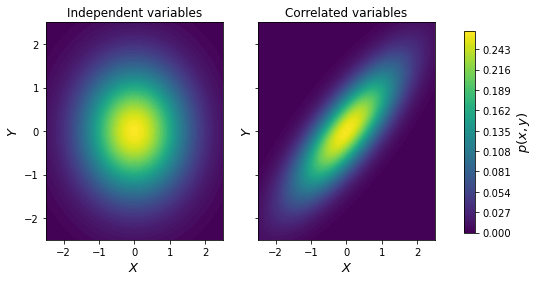

In [4]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8,4), sharey=True)
d = 2 

mean_ind = np.matrix([[0.], [0.]])
covariance_ind = np.matrix([
    [1., 0.], 
    [0., 1.]])
x, y, p = calculate_pdf(
    mean_ind, covariance_ind, d)

ax[0].contourf(x, y, p, 100)
ax[0].set_xlabel('$X$', fontsize=13)
ax[0].set_ylabel('$Y$', fontsize=13)
ax[0].axis([-2.5, 2.5, -2.5, 2.5])

mean_corr = np.matrix([[0.], [0.]])
covariance_corr = np.matrix([
    [1., 0.8], 
    [0.8, 1.]])
x, y, p = calculate_pdf(
    mean_corr, covariance_corr, d)

con = ax[1].contourf(x, y, p, 100)
ax[1].set_xlabel('$X$', fontsize=13)
ax[1].set_ylabel('$Y$', fontsize=13)
ax[1].axis([-2.5, 2.5, -2.5, 2.5])

ax[0].set_title('Independent variables', fontsize=12)
ax[1].set_title('Correlated variables', fontsize=12)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
cbar = fig.colorbar(con, cax=cbar_ax)
cbar.ax.set_ylabel('$p(x, y)$', fontsize=13)
plt.show()

The reason why the multivariate Gaussian is so useful is due to its algebric properties, which ensure that when marginalizing and conditioning we get also Gaussian distributions.

Marginalization means integrating out variables from the original set of variables. The result is the distribution of a subset of the variables without any reference to the ones that we integrated out. So if we only interested in the probability density of $X$:

$$
P(x) = \int_y P(x,y)dy = \int_y P(x|y)p(y)dy
$$

And, as I stated earlier, this also results in a Gaussian distribution:

$$\begin{aligned}
X \sim \mathcal{N}(\mu_x, \Sigma_{xx})
\end{aligned}$$

In [5]:
def univariate_normal(x, mean, variance):
    return ((1. / np.sqrt(2 * np.pi * variance)) * 
            np.exp(-(x - mean)**2 / (2 * variance)))

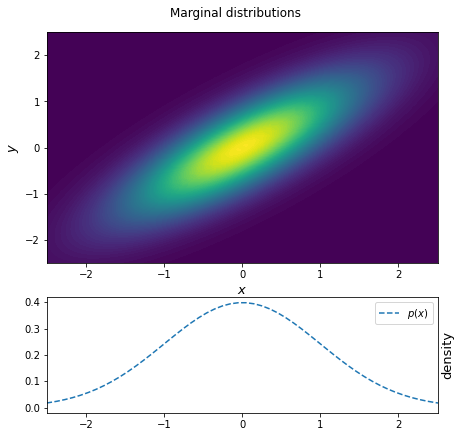

In [6]:
fig = plt.figure(figsize=(7, 7))
gs = gridspec.GridSpec(
    2, 1, height_ratios=[2, 1])
plt.suptitle('Marginal distributions', y=0.93)

ax1 = plt.subplot(gs[0])
x, y, p = calculate_pdf(mean_corr, covariance_corr, d)
con = ax1.contourf(x, y, p, 100)
ax1.set_xlabel('$x$', fontsize=13)
ax1.set_ylabel('$y$', fontsize=13)
ax1.axis([-2.5, 2.5, -2.5, 2.5])

ax2 = plt.subplot(gs[1])
x = np.linspace(-5, 5, 100)
px = univariate_normal(x, mean_corr[0,0], covariance_corr[0, 0])
ax2.plot(x, px, '--', label=f'$p(x)$')
ax2.legend(loc=0)
ax2.set_ylabel('density', fontsize=13)
ax2.yaxis.set_label_position('right')
ax2.set_xlim(-2.5, 2.5);

The same happen when conditioning, which is the probability of one variable depending on another.

$$\begin{aligned}
X|Y \sim \mathcal{N}(\mu_x + \Sigma_{xy}\Sigma^{-1}_{yy}(y-\mu_y), \Sigma_{xx} - \Sigma_{xy} \Sigma^{-1}_{yy}\Sigma_{yx})
\end{aligned}$$

$$\begin{aligned}
Y|X \sim \mathcal{N}(\mu_y + \Sigma_{yx}\Sigma^{-1}_{xx}(x-\mu_x), \Sigma_{yy} - \Sigma_{yx} \Sigma^{-1}_{xx}\Sigma_{xy})
\end{aligned}$$

Let's calculate $p(X|y=1)$ for our example:

In [7]:
y_cond = 1.
mean_x_cond_y = mean_corr[0,0] + (covariance_corr[0, 1]*(1/covariance_corr[1, 1])*(1 - mean_corr[1, 0]))
cov_x_cond_y = covariance_corr[0,0] - covariance_corr[0,1]*(1/covariance_corr[1,0]) * covariance_corr[0,1]

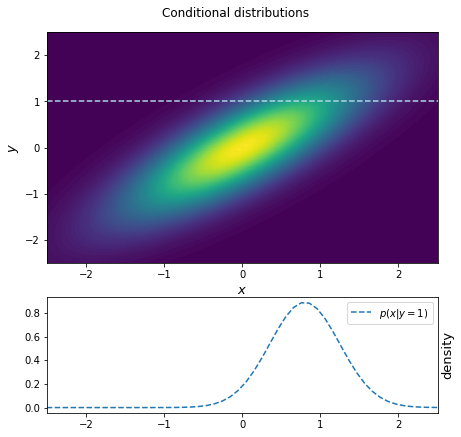

In [8]:
fig = plt.figure(figsize=(7, 7))
gs = gridspec.GridSpec(
    2, 1, height_ratios=[2, 1])
plt.suptitle('Conditional distributions', y=0.93)

ax1 = plt.subplot(gs[0])
x, y, p = calculate_pdf(mean_corr, covariance_corr, d)
con = ax1.contourf(x, y, p, 100)
ax1.set_xlabel('$x$', fontsize=13)
ax1.set_ylabel('$y$', fontsize=13)
ax1.axis([-2.5, 2.5, -2.5, 2.5])
ax1.plot([-2.5, 2.5], [y_cond, y_cond], color='lightblue', linestyle='dashed')

ax2 = plt.subplot(gs[1])
x = np.linspace(-5, 5, num=100)
px = univariate_normal(x, mean_x_cond_y, cov_x_cond_y)
ax2.plot(x, px, '--', label=f'$p(x|y=1)$')
ax2.legend(loc=0)
ax2.set_ylabel('density', fontsize=13)
ax2.yaxis.set_label_position('right')
ax2.set_xlim(-2.5, 2.5);

## 2.2 Gaussian Process Regression

Now that we understand the properties of the multivariate Gaussian, it is time to see how to combine them to solve regression problems. First we need to introduce some concepts. 

The basic idea when performing a Gaussian process regression is that our Gaussian process will assign a probability to the potentially infinite functions that could fit our data. This probability expresses the uncertainty of the model, which gives us a strong indication of how much should we trust the point prediction - i.e. the mean of the resulting probability distribution.


## 2.3 Kernels

The kernels define the types of functions that we will be able to sample from our distribution of functions. Despite the fact that the Gaussian processes are non-parametric methods, the kernels have parameters that allows us to control the shape of that specific type of functions. Let's work out an example to understand what does this mean.

One of the most used kernels is the squared exponential kernel:

$$k(x_i, x_i) = \eta^2\exp\big(-\frac{1}{2l^2}(x_i-x_j)^T(x_i - x_j)\big)$$

where the length $l$ controls the smoothness and $\eta$ the amplitude of the function.

In [2]:
az.style.use('arviz-darkgrid')
def sq_e_kernel(x1, x2, l=1.0, η=1.0):
    sqdist = np.sum(x1**2,1).reshape(-1,1) + np.sum(x2**2, 1) - 2 * np.dot(x1, x2.T)
    return η**2 * np.exp(-0.5 / l**2 * sqdist)

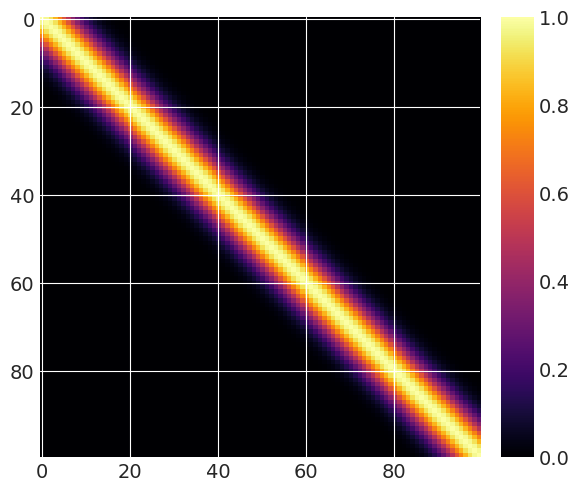

In [3]:
# Finite number of points
X = np.arange(0, 100).reshape(-1, 1)

cov = sq_e_kernel(X, X, l=5)
m = plt.imshow(cov, cmap="inferno", interpolation='none')
plt.colorbar(m);

If we plot the first line of the covariance function we can see the exponential decay based on the distance between points that this function produces.

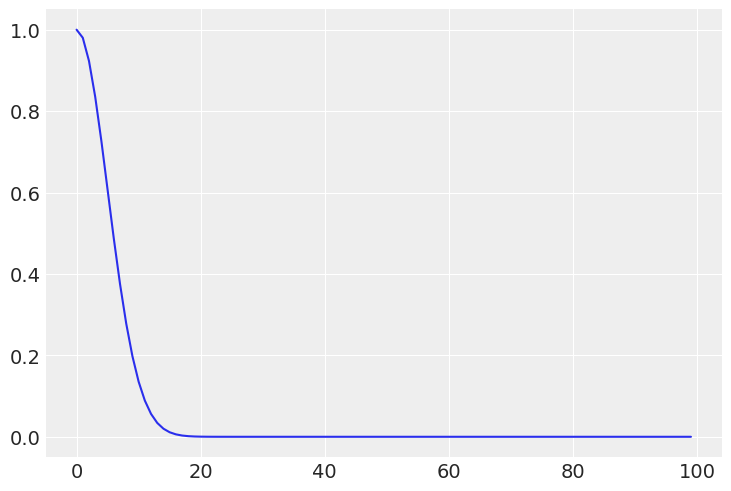

In [4]:
plt.plot(cov[:,0]);

## 2.4 Prior

What we defined above was the covariance matrix of our multivariate distribution. It means that we can finally have access to realizations of our functions, we just need to sample from our multivariate Gaussian distribution. We can do the sampling without actually observing any training point and this is extremely helpful when doing prior predictive checks - we will make use of this Bayesian feature in our analysis of the covid19 data.

Let's define $\mu=0$ for our Gaussian process. We will see that we can model all kinds of behaviors using only the covariance matrix, through different kernels or combinations of kernels. It is a standard practice to let our $\mu=0$.

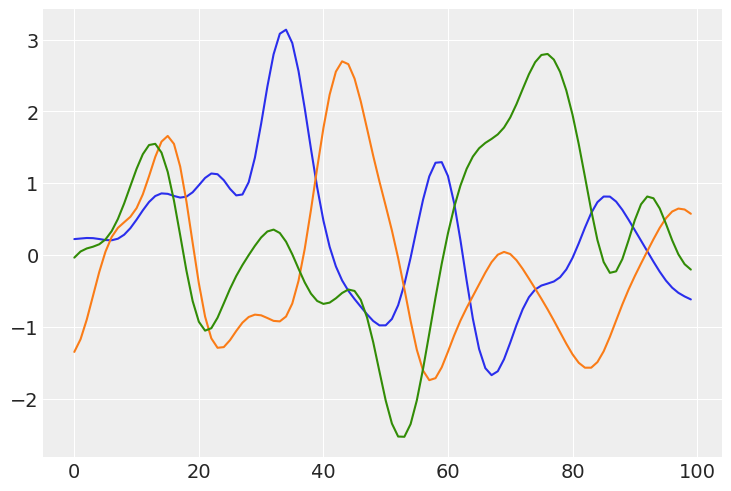

In [5]:
samples = np.random.multivariate_normal(np.zeros(100), cov, size=3)
plt.plot(samples.T);

We can control the parameters of the kernel or combination of kernels to reshape the resulting functions. Below, you can find 3 different combinations of parameters using the squared exponential kernel.

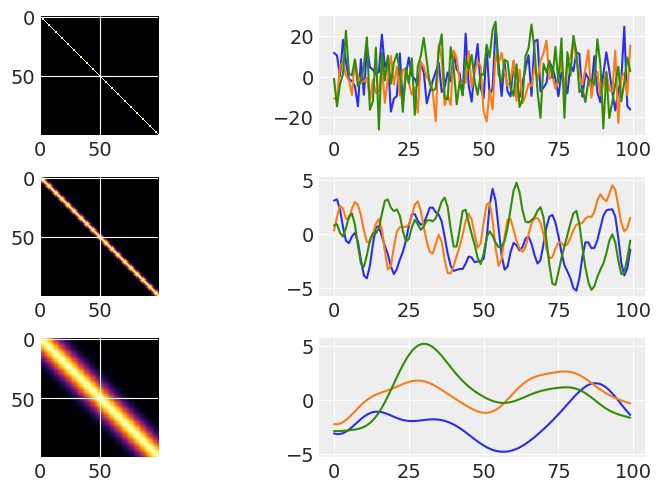

In [13]:
_, ax = plt.subplots(3, 2)
ax = ax.ravel()

l_p = [0.1, 2, 10]
η_p = [10, 2, 2]

for i in range(6):
    cov = sq_e_kernel(X, X, η=η_p[i//2], l=l_p[i//2])
    if not i%2:
        ax[i].imshow(cov, cmap="inferno", interpolation='none')
        samples = np.random.multivariate_normal(np.zeros(100), cov, size=3)
    else:
        ax[i].plot(samples.T)

## 2.5 Posterior

To finish the theorical introduction we need to plug in our test points, i.e. new points where we want to estimate new functions. This is where we make use of the conditional property of the multivariate Gaussian, which, as we saw above, also results in a Gaussian distribution. 

$$\begin{aligned}
p(f_*| X_*, X, f) \sim \mathcal{N}(K_*^TK^{-1}f, K_{**} - K_{*}^T K^{-1}K_{*})
\end{aligned}$$


In the expression above we are assuming no noise in both our training data and predictions. Including noise in our training data is made by independently add noise to each observation $\epsilon \sim \mathcal{N}(0, \sigma^2_yI)$. To consider noise in the predictions, we add it to the diagonal of $K_{**}$.

If no error term is considered in the first case, the set of functions resultant of the conditioning will pass exactly through each training point. In the latter case, the inclusion of noise can be seen as adding a white noise kernel to our current one, which help to model small irregularities in our predictions.

In [14]:
def posterior(X_s, X_train, Y_train, l=1.0, η=1.0, noise_train=1e-8, noise_predict=1e-8):

    K = sq_e_kernel(X_train, X_train, l, η) + noise_train**2 * np.eye(len(X_train))
    K_s = sq_e_kernel(X_train, X_s, l, η)
    K_ss = sq_e_kernel(X_s, X_s, l, η) + noise_predict**2 * np.eye(len(X_s))
    K_inv = inv(K)
    
    mu_s = K_s.T.dot(K_inv).dot(Y_train)
    cov_s = K_ss - K_s.T.dot(K_inv).dot(K_s)
    
    return mu_s, cov_s

Let's use our posterior function to condition our prior on new points $X_*$. First, we define a our training data without any noise and fit predictions also without considering any noise.

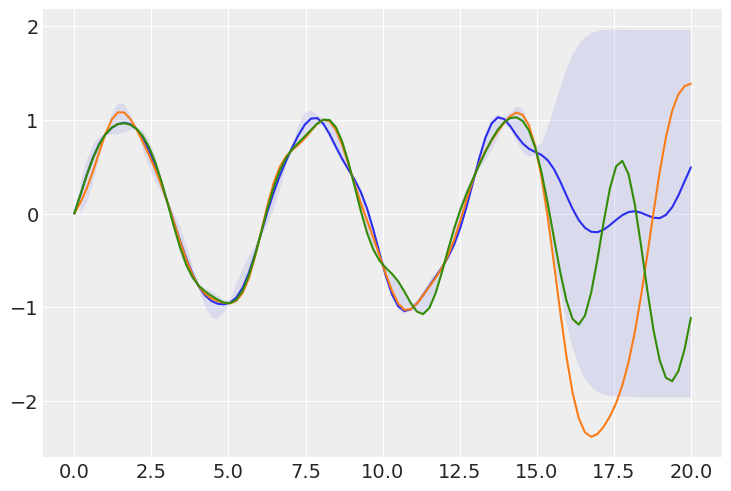

In [23]:
X_train = np.arange(0,16).reshape(-1,1)
Y_train = np.sin(X_train)

X = np.linspace(0, 20, 100).reshape(-1, 1)
mu_new, cov_new = posterior(X, X_train, Y_train, noise_train=0, noise_predict=0)

samples = np.random.multivariate_normal(mu_new.ravel(), cov_new, 3)
uncertainty = 1.96 * np.sqrt(np.diag(cov_new))
plt.plot(X.ravel(),samples.T)
plt.fill_between(X.ravel(), mu_new.ravel() + uncertainty, mu_new.ravel() - uncertainty, alpha=0.1);

When we add noise to our training data but not adding any to our model, we can see that we completely overfit the irregular behavior of the data.

On the other hand, when we model the noise (on the second plot), we can see that we are able to recover much better the underlying pattern present in the data.

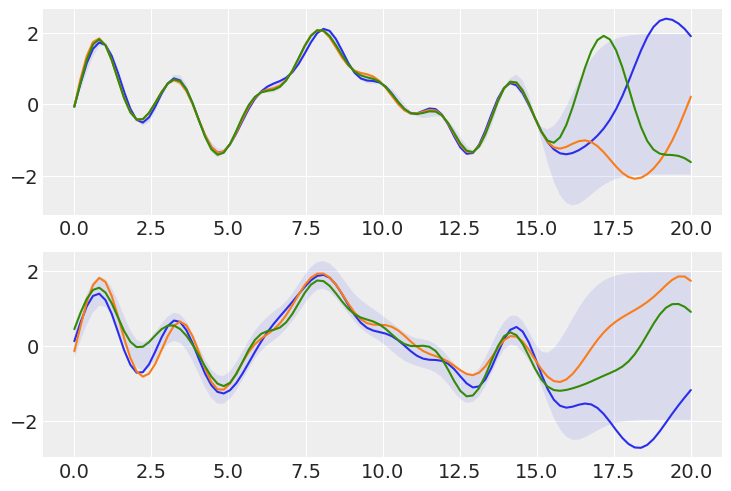

In [33]:
noise_train = 0.8
X_train = np.arange(0,16).reshape(-1,1)
Y_train = np.sin(X_train) + noise_train * np.random.randn(*Y_train.shape)

_, ax = plt.subplots(2, 1)
X = np.linspace(0, 20, 100).reshape(-1, 1)
mu_new, cov_new = posterior(X, X_train, Y_train, noise_train=0, noise_predict=0)

samples = np.random.multivariate_normal(mu_new.ravel(), cov_new, 3)
uncertainty = 1.96 * np.sqrt(np.diag(cov_new))
ax[0].plot(X.ravel(),samples.T)
ax[0].fill_between(X.ravel(), mu_new.ravel() + uncertainty, mu_new.ravel() - uncertainty, alpha=0.1);

mu_new, cov_new = posterior(X, X_train, Y_train, noise_train=0.2)
samples = np.random.multivariate_normal(mu_new.ravel(), cov_new, 3)
uncertainty = 1.96 * np.sqrt(np.diag(cov_new))
ax[1].plot(X.ravel(),samples.T)
ax[1].fill_between(X.ravel(), mu_new.ravel() + uncertainty, mu_new.ravel() - uncertainty, alpha=0.1);

## 2.6 Maximum a Posteriori

One way to estimate our parameters is by maximizing the log marginal likelihood (to understand how this expression is derived see [[3]](https://towardsdatascience.com/first-bayesian-state-space-model-with-pymc3-51cbb06ef8bd)),

$$\log p(y|X) = \log \mathcal{N}(y|0, K + \sigma^2_yI) = -\frac{1}{2}y^T(K+\sigma^2_yI)^{-1}y - \frac{1}{2}\log |(K+\sigma^2_yI)| - \frac{N}{2} \log(2\pi)$$

which is equivalent to minimize the negative log marginal likelihood, which is often preferred (see [[4]](http://krasserm.github.io/2018/03/19/gaussian-processes/) for an extension of these ideas).

l_opt:1.94
noise_train_opt:0.71


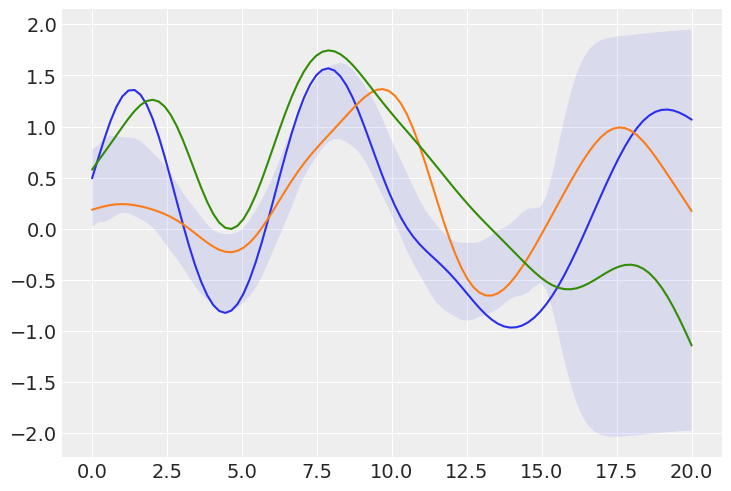

In [34]:
def l_fn(X_train, Y_train):
    """Partially adapted from http://krasserm.github.io/2018/03/19/gaussian-processes/"""
    Y_train = Y_train.ravel()
    def negative_log_like(theta):
        K = sq_e_kernel(X_train, X_train, l=theta[0]) + theta[1]**2 * np.eye(len(X_train))
        return (0.5 * np.log(det(K))
                + 0.5 * Y_train.dot(inv(K).dot(Y_train))
                + 0.5 * len(X_train) * np.log(2*np.pi))
    return negative_log_like


res = minimize(l_fn(X_train, Y_train),
               [1.,1.],
               method='L-BFGS-B')

l_opt, noise_train_opt = res.x

print('l_opt:' + str(np.round(l_opt, 2)))
print('noise_train_opt:' + str(np.round(noise_train_opt, 2)))

mu_s, cov_s = posterior(X, X_train, Y_train, l=l_opt, noise_train=noise_train_opt)
plt.plot(X.ravel(), np.random.multivariate_normal(mu_s.ravel(), cov_s, 3).T)
plt.fill_between(X.ravel(), mu_s.ravel() + uncertainty, mu_s.ravel() - uncertainty, alpha=0.1);

# 3. Model

## 3.1 Data

In [111]:
covid19 = pd.read_csv('.data/owid-covid-data20210120.csv')

covid = covid19[['location', 'continent', 'date', 'new_cases']] 
covid.columns = ['Country', 'Continent', 'Date', 'Count']
covid['Date'] = covid['Date'].astype('datetime64[ns]')
covid_pt = covid.loc[covid['Country']=='Portugal'].set_index('Date')
covid_pt = covid_pt.dropna()

In [113]:
dates = covid_pt.index
c_pt = covid_pt['Count'].fillna(0).reset_index().set_index('Date')['Count'].values
c_pt = np.abs(c_pt)
X = np.arange(c_pt.shape[0]).reshape(-1,1)

Below we can see the evolution of the new cases in Portugal. As I stated earlier, the spread of a pandemic has a known dynamic. Nonetheless, in this case we can see that actions have been taken with different results across time. In the first wave of the spread of the virus, Portugal was considered one of the good examples of containing it. It was both due to political measures and also because of the behavior of the general population. The same didn't happen in the second wave, where lack of planning led us to a challenging situation. Right now, we are ranked as one of the worst countries in the world when analyzing the data. We are dealing with a unprecedent rise of the number of cases, which are causing the collapse of our Health System.

The data comprises values from 02–03–2020 to 19–01–2021. Remember that the values always refer to the day before, so the last day present in the dataset is in fact the 18th of January.

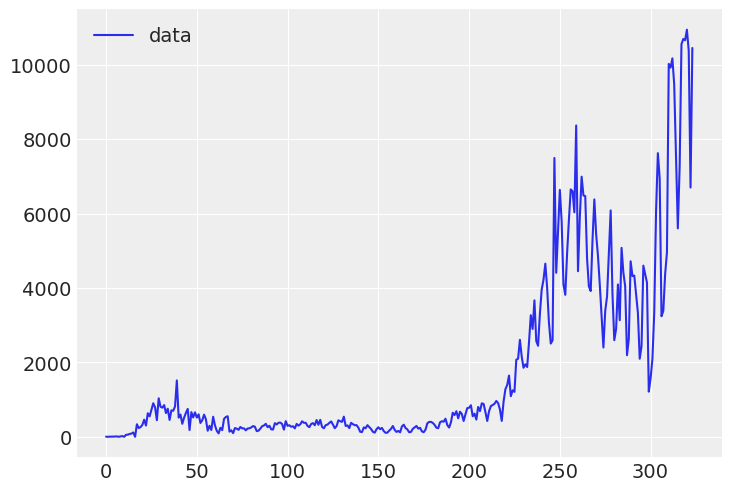

In [37]:
n = c_pt.shape[0]

plt.plot(np.arange(n), c_pt, label='data')
plt.legend();

## 3.2 Model implementation

### 3.2.1 Kernels

Kernels can be classified into stationary and non-stationary (see my other article to know more about these concepts [[5]](https://towardsdatascience.com/5-levels-of-difficulty-bayesian-gaussian-random-walk-with-pymc3-and-theano-34343911c7d2)). Stationary kernels will always return to the mean of the Gaussian process in regions that are further away from observed points. This happens because the covariance that is being modeled between points depends only on their relative position and not on their absolute distance. An example could be an exponentiated quadratic kernel or a periodic kernel. On the other hand, a linear kernel is a non-stationary kernel. Our model is a sum of three GPs for the signal and one GP for the noise:

1. An exponential quadratic kernel to model medium term irregularities (the different waves)
2. A periodic term for the weekly seasonality.
3. A linear kernel to account for the trend (exponential in this case)
4. The noise is modeled as a white noise kernel

The prior on $y$ as a function of time is,

\begin{equation}f(t) \sim GP_{t}(0, k_1(x, x')) + GP_{per}(0, k_2(x, x')) + GP_{lin}(0, k_3(x, x')) + GP_{noise}(0, k_4(x,x'))
\end{equation}

### 3.2.2 Mean Function

If we didn't specify a mean function in our model, we are assuming that our GP has a mean of zero. If we only used stationary kernels, this would mean that as we forecast into the future, the function would eventually return to zero. Is this a reasonable assumption? Probably this is not the case for this pandemic - we will have to live with it in the future. The measures that are being taken have the main goal to control the rate of spread not exactly to make it vanish from the earth. With all of this being said, we could use a mean function different from zero and I added the code to do it below. Nevertheless, the approach used in our model will use a linear kernel instead.

In [38]:
from pymc3.gp.mean import Mean

class Linear(Mean):
    def __init__(self, b, a=0):
        Mean.__init__(self)
        self.a = a
        self.b = b

    def __call__(self, X):
        return tt.squeeze(tt.dot(X, self.b) + self.a)

### 3.3.3 Likelihood

In our case we are dealing with count data. Therefore, we want to use one or more GPs as latent processes that estimate a Poisson mean (and standard deviation, as they are the same).

$$\begin{align}
\theta &\sim g(\phi) \\
f &\sim \textrm{MvNormal}(0, K_{theta}(x)) \\
y_i &\sim \textrm{Poisson}(\exp(f_i)) \forall i \in {1,...,n} 
\end{align}$$

When we use a distribution as the Poisson, we need to ensure that the parameter that we are estimating for the distribution is constraint to the positive real numbers. It can be guaranteed by using the conventional log-link function - this way $\exp(f_i)$ is always positive.

### 3.3.4 Using reparameterization to speed up

I am adding this small section just to give you visibility on the default parameterization of `PyMC3`. It uses a non-centered parameterization of our multivariate normal. We already know that the samples from a Gaussian process are realizations of a multivariate normal with a parameterized covariance matrix. The best way to add a multivariate normal density over $f$ to the log-posterior density, is by using a Cholesky decomposition to get the factor $L$ and multiplying it by a vector of univariate normal random variables. 

\begin{align}
\eta_i &\sim \mathcal{N}(0,1) \forall i \in {1,..,n} \\
f &= L\eta \\
f &\sim \text{MvNormal}(0, \Sigma)
\end{align}

The prior dependency of the density of $f$ on its hyperparameters (kernel parameters) is therefore removed.

### 3.3.5 Hyperparameters prior distributions

It is a good practice to always do some kind of prior predictive checks and thus ensure that the prior distributions of all parameters are well defined. In this case, I would say that it is even more important due to the flexibility of the Gaussian processes. They can easily overfit the data and give you unexpected results. It is extremely important that you use informative priors (see here a very good article on the subject [[6]](https://betanalpha.github.io/assets/case_studies/gaussian_processes.html)).

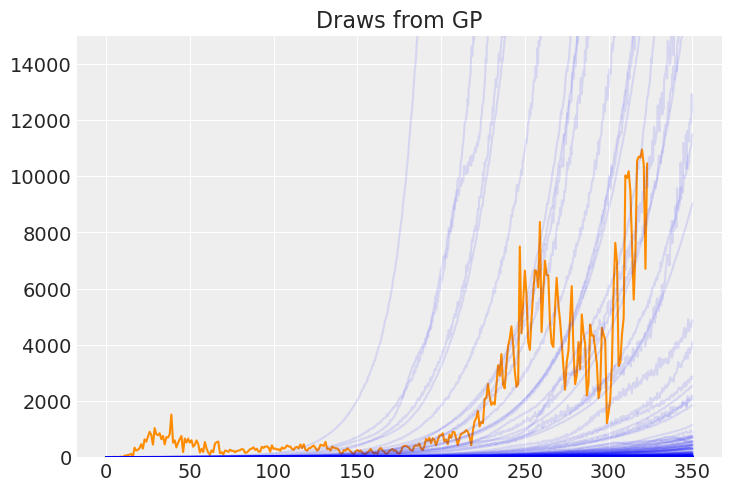

In [77]:
X_ = np.linspace(0, 350,1000)[:, None]

with pm.Model() as model_prior:
    l_t = pm.InverseGamma('l_t', 4, c_pt.shape[0]/4)
    l_p = pm.InverseGamma('l_p', 4, c_pt.shape[0])
    c = pm.Normal('c', 0, 0.05)

    η_trend = pm.HalfNormal('η_trend',0.1)
    η_ts = pm.HalfNormal('η_ts', 0.01)
    η_per = pm.HalfNormal('η_per', 0.2)
    σ  = pm.HalfNormal("σ",  sigma=0.02)


    cov = (η_trend**2 * pm.gp.cov.ExpQuad(input_dim=1, ls=l_t)
           + η_ts**2 * pm.gp.cov.Linear(input_dim=1, c=c)
           + η_per**2 * pm.gp.cov.Periodic(1, period=7, ls=l_p)
            + pm.gp.cov.WhiteNoise(σ))
    
    
    gp = pm.gp.Latent(mean_func = pm.gp.mean.Zero(), cov_func = cov)
    
    f = gp.prior("f", X=X_)
    f_ = pm.Deterministic('f_', tt.exp(f))
    
    prior_checks = pm.sample_prior_predictive(samples=1000)
    
plt.plot(c_pt, color='darkorange')
plt.plot(X_, prior_checks['f_'].T, color='b', alpha=0.1)
plt.ylim(0, 15000)
plt.title('Draws from GP');

We can see that our prior samples are somewhat contained in the range of our data.

### 3.3.6 All together now

Below you can find the model that we will fit to the COVID-19 new cases in Portugal since the pandemic reached the country.

In [71]:
with pm.Model() as model:

    l_t = pm.InverseGamma('l_t', 4, c_pt.shape[0]/4)
    l_p = pm.InverseGamma('l_p', 4, c_pt.shape[0])
    c = pm.Normal('c', 0, 0.05)

    η_trend = pm.HalfNormal('η_trend',0.1)
    η_ts = pm.HalfNormal('η_ts', 0.01)
    η_per = pm.HalfNormal('η_per', 0.2)
    σ  = pm.HalfNormal("σ",  sigma=0.02)
    
    cov = (η_trend**2 * pm.gp.cov.ExpQuad(input_dim=1, ls=l_t)
           + η_ts**2 * pm.gp.cov.Linear(input_dim=1, c=c)
           + η_per**2 * pm.gp.cov.Periodic(1, period=7, ls=l_p)
            + pm.gp.cov.WhiteNoise(σ))
    
    
    gp = pm.gp.Latent(mean_func = pm.gp.mean.Zero(), cov_func = cov)
    f = gp.prior('f', X=X, reparameterize=True)


    y_pred = pm.Poisson('y_pred', mu=tt.exp(f), observed=c_pt)
    mp = pm.find_MAP(maxeval=20000, progressbar = True)

Now, it it time to condition our model on the new data, i.e. the 30 new time points that we want to forecast.

In [72]:
X_new = np.arange(c_pt.shape[0]+30).reshape(-1,1)
with pm.Model() as model:
    f_n = gp.conditional('f_n', Xnew=X_new)

    y_pred_new = pm.Poisson("y_pred_new", 
                            mu=tt.exp(f_n), 
                            shape=X_new.shape[0])

    pred_samples = pm.sample_posterior_predictive([mp], 
                                              vars=[y_pred_new], 
                                              samples=200,
                                              progressbar = False)

# 4. Results and Discussion

Finally, let's plot our results.

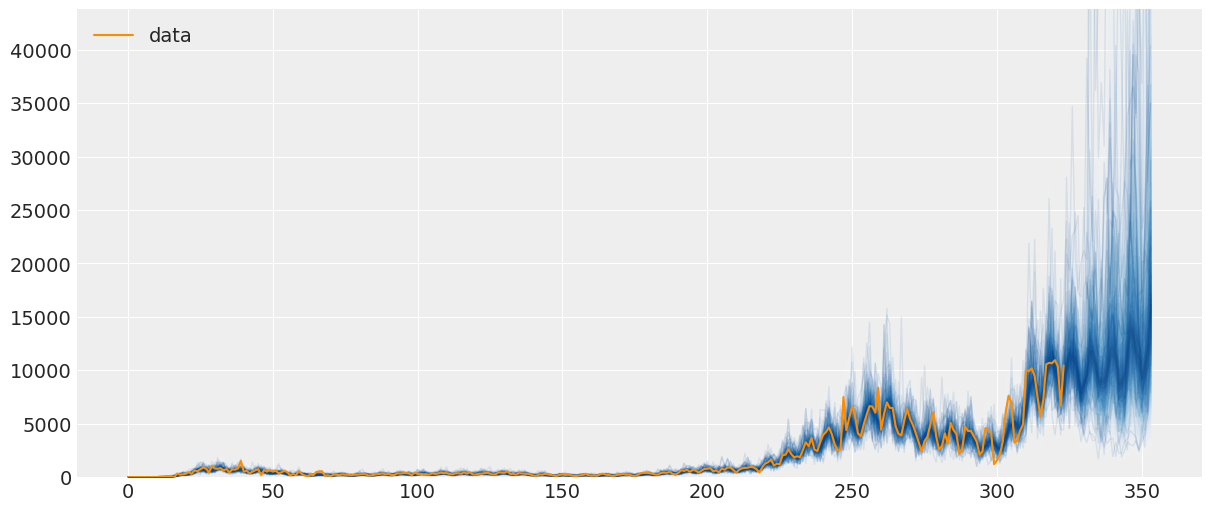

In [79]:
from pymc3.gp.util import plot_gp_dist
fig = plt.figure(figsize=(12,5)); ax = fig.gca()

plot_gp_dist(ax, pred_samples['y_pred_new'], X_new, palette="Blues", fill_alpha=0.1, samples_alpha=0.1);
plt.plot(np.arange(c_pt.shape[0]),c_pt, label='data', color='darkorange')
plt.ylim(0,max(c_pt)*4)
plt.legend();

In [74]:
n_new = X_new.shape[0]

Zooming in the 30 days that we are forecasting the news are not good. The model estimates an average number of cases that goes up to 24.047. But more importantly it also tells us that, in the case of measures such as the lockdown are very effective, the peak of 24.047 could be as low as 8.753 (the bottom of the 50% interval) or as high as 29.939 (the top of the 50% interval). You can also see the more extreme cases regarding the 90% credible interval.

As I was finish writing this article the number of new cases for today was announced and I added it in red. Unfortunately, we can see that is on the top end of our interval, between the 50% and the 90% interval. It could be just an irregularity (such as some result of more tests, data registry, cumulative effect of previous days or other) or it could indicate a change of behavior.

In [89]:
mean_values = pd.DataFrame({'x':np.arange(n, n_new), 'y':np.mean(pred_samples['y_pred_new'], axis=0)[-30:]})
top_mean_values = pd.DataFrame(columns=['x', 'y'])
top_mean_values['x'] = [mean_values[(i)*6:(i+1)*6].sort_values(by='y', ascending=False)[:1].values[0][0] for i in range(5)]
top_mean_values['y'] = [mean_values[(i)*6:(i+1)*6].sort_values(by='y', ascending=False)[:1].values[0][1] for i in range(5)]

low_q25_values = pd.DataFrame({'x':np.arange(n, n_new), 'y':np.percentile(pred_samples['y_pred_new'], axis=0, q=[25]).ravel()[-30:]})
low_q25_values = low_q25_values.loc[low_q25_values.x.isin(top_mean_values.x)]
high_q25_values = pd.DataFrame({'x':np.arange(n, n_new), 'y':np.percentile(pred_samples['y_pred_new'], axis=0, q=[75]).ravel()[-30:]})
high_q25_values = high_q25_values.loc[high_q25_values.x.isin(top_mean_values.x)]

low_q10_values = pd.DataFrame({'x':np.arange(n, n_new), 'y':np.percentile(pred_samples['y_pred_new'], axis=0, q=[10]).ravel()[-30:]})
low_q10_values = low_q10_values.loc[low_q10_values.x.isin(top_mean_values.x)]
high_q10_values = pd.DataFrame({'x':np.arange(n, n_new), 'y':np.percentile(pred_samples['y_pred_new'], axis=0, q=[90]).ravel()[-30:]})
high_q10_values = high_q10_values.loc[high_q10_values.x.isin(top_mean_values.x)]

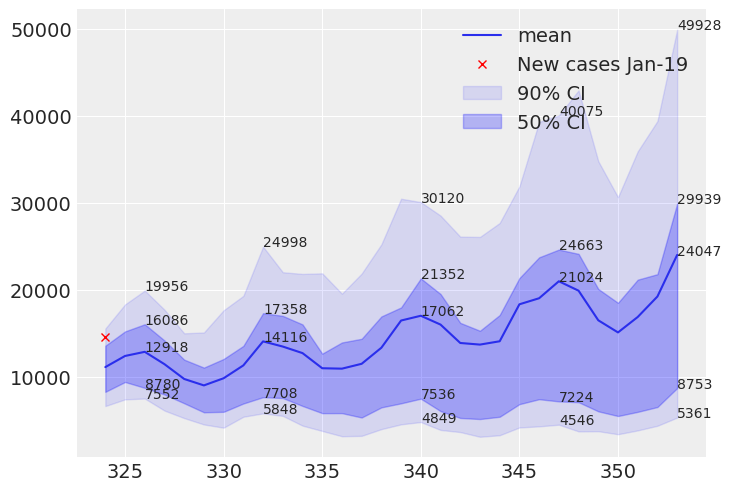

In [110]:
plt.fill_between(np.arange(n, n_new), np.percentile(pred_samples['y_pred_new'], axis=0, q=[10]).ravel()[-30:],
                 np.percentile(pred_samples['y_pred_new'], axis=0, q=[90]).ravel()[-30:], alpha = 0.1, color='b', label='90% CI');
plt.fill_between(np.arange(n, n_new), np.percentile(pred_samples['y_pred_new'], axis=0, q=[25]).ravel()[-30:],
                 np.percentile(pred_samples['y_pred_new'], axis=0, q=[75]).ravel()[-30:], alpha = 0.25, color='b', label='50% CI');
plt.plot(np.arange(n, n_new), np.mean(pred_samples['y_pred_new'], axis=0)[-30:], label='mean')
for i, j in zip(top_mean_values.x, top_mean_values.y):
    plt.annotate(str(int(j)), xy=(i,j))
for i, j in zip(low_q25_values.x, low_q25_values.y):
    plt.annotate(str(int(j)), xy=(i,j))
for i, j in zip(low_q10_values.x, low_q10_values.y):
    plt.annotate(str(int(j)), xy=(i,j))
for i, j in zip(high_q25_values.x, high_q25_values.y):
    plt.annotate(str(int(j)), xy=(i,j))
for i, j in zip(high_q10_values.x, high_q10_values.y):
    plt.annotate(str(int(j)), xy=(i,j))
    
plt.plot(324, 14674, 'rx', label='New cases Jan-19')
plt.legend();

# 5. Conclusion

The goal of this article is to show the strength and flexibility of Gaussian processes when dealing with patterns that are challenging to fit. With such power comes great responsibility, especially when it comes to overfitting. When we care to take the time to choose our kernels wisely and define informative priors on their parameters we can fit almost any kind of data with them. We saw that a pattern so irregular as the Portuguese new cases of COVID-19 per day was relatively well described by our model. I say relatively well because we should evaluate our forecasts with error metrics, compare with baseline models and apply our model to different scenarios (other countries, other metrics such as the number of deaths, etc). Another important aspect to consider when using Gaussian processes is that they are not known to be very scalable (O(n³)), despite the fact that there are interesting approaches to increase their scalability (e.g. [[7]](https://arxiv.org/abs/1411.2005)). 

This article is a scientific exercise, please do not take any action based on its results.

# References

[1] - https://ourworldindata.org/grapher/rate-of-daily-new-confirmed-cases-of-covid-19-positive-rate?tab=table&yScale=linear&time=earliest..latest

[2] - https://distill.pub/2019/visual-exploration-gaussian-processes/

[3] - https://towardsdatascience.com/first-bayesian-state-space-model-with-pymc3-51cbb06ef8bd

[4] - http://krasserm.github.io/2018/03/19/gaussian-processes/

[5] - https://towardsdatascience.com/5-levels-of-difficulty-bayesian-gaussian-random-walk-with-pymc3-and-theano-34343911c7d2

[6] - https://betanalpha.github.io/assets/case_studies/gaussian_processes.html

[7] - https://arxiv.org/abs/1411.2005